### Jacobian free inverse problem

In [1]:
from jax import numpy as jnp
import numpy as np
from functools import partial
from jax import random
import jax
from matplotlib import pyplot as plt

key = random.PRNGKey(42)

In [2]:
# Defining geometry
from jwave.geometry import Domain, Medium, _circ_mask

N = (128, 128)         # Grid size
dx = (1., 1.)          # Spatial resolution
omega = 1.              # Wavefield omega = 2*pi*f
target = [40,105]

# Making geometry
domain = Domain(N, dx)

# Build the vector that holds the parameters of the apodization an the
# functions required to transform it into a source wavefield
transmit_phase = jnp.concatenate([jnp.ones((2,)), jnp.ones((2,))])
position = list(range(32, 32+4, 2))

src_field = jnp.zeros(N).astype(jnp.complex64)
src_field = src_field.at[64, 22].set(1.0)

In [3]:
def show_field(field):
    fig, axes = plt.subplots(2,1,figsize=(15,8))

    axes[0].imshow(field.real, vmin=-.2, vmax=.2, cmap="seismic")
    axes[0].set_title("Real wavefield")
    axes[1].imshow(jnp.abs(field), vmin=0, vmax=.1, cmap="magma")
    axes[1].set_title("Wavefield magnitude")

In [49]:
from jwave.signal_processing import smooth

def sos_func(sos_array):
    sos = 1 + jax.nn.sigmoid(sos_array)
    sos_padded = jnp.ones(N)
    return smooth(sos_padded.at[15:-15,15:-15].set(sos))

sos_array = jnp.zeros(list(map(lambda x: x-30, N))) - 2

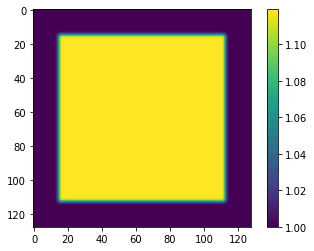

In [51]:
sos_map = sos_func(sos_array)
plt.imshow(sos_map)
plt.colorbar()

In [52]:
# Constructing medium physical properties
medium = Medium(
    domain=domain,
    sound_speed=sos_map,
    density=1.,
    attenuation=None,
    pml_size=10
)

In [67]:
# Solve using standard implicit function theorem
from jwave.acoustics import ongrid_helmholtz_solver
from jax import jit

params, solver = ongrid_helmholtz_solver(
        medium, 
        omega=omega,
        tol=1e-5, 
        restart=5,
        method="gmres",
        maxiter=1000,
        source = src_field
    )

In [54]:
from jax import value_and_grad

def loss(sos_array):
    sos_map = sos_func(sos_array)
    params["c"] = jnp.expand_dims(sos_map, -1)
    field = solver(params)
    return -jnp.abs(field[target[0], target[1],0])

vg_loss = jit(value_and_grad(loss))

In [55]:
lossval, gradient = vg_loss(sos_array)

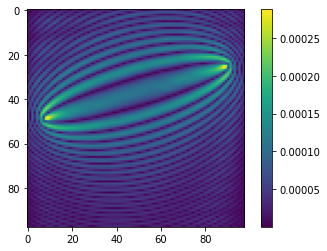

In [56]:
plt.imshow(jnp.abs(gradient))
plt.colorbar()

In [57]:
lossval

DeviceArray(-0.02342083, dtype=float32)

In [58]:
from jax.experimental import optimizers

init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(sos_array)

@partial(jit)
def update(opt_state):
    lossval, gradient = vg_loss(get_params(opt_state))
    return lossval, update_fun(k, gradient, opt_state)

In [59]:
from tqdm import tqdm

pbar = tqdm(range(100))
losshistory = []

for k in pbar:
    lossval, opt_state = update(opt_state)
    
    if k == 0:
        avg_loss = lossval
    else:
        avg_loss = 0.5*avg_loss + 0.5*lossval
        
    #if lossval > avg_loss:
    #    tol = max([tol/10, 1e-5])
        
    # For logging
    pbar.set_description("Avg. ampl: {:01.4f} | Ampl: {:01.4f}".format(-avg_loss, -lossval))
    losshistory.append(lossval)

Tol: 0.001 | Avg. ampl: 2.5561 | Ampl: 2.5670: 100%|█████████████████████████████| 100/100 [03:11<00:00,  1.91s/it]


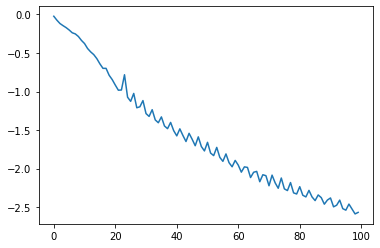

In [60]:
plt.plot(losshistory)

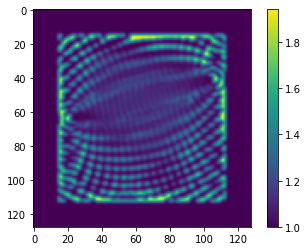

In [61]:
opt_sos_array = get_params(opt_state)
sos_map = sos_func(opt_sos_array)
plt.imshow(sos_map)
plt.colorbar()

Richardson gradient

In [181]:
from jwave.acoustics import helmholtz_on_grid
from jax.lax import stop_gradient

init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(sos_array)

# Getting the Helmholtz operator
_, f = helmholtz_on_grid(
    medium,
    omega,
    source=src_field
)

def loss(sos_array):
    sos_map = sos_func(sos_array)
    params["c"] = jnp.expand_dims(sos_map, -1)
    field = solver(params)
    return -jnp.abs(field[target[0], target[1],0])

vg_loss = jit(value_and_grad(loss))

@partial(jit)
def update(opt_state):
    sos_array = get_params(opt_state)
    
    # Find the solution field
    sos_map = sos_func(sos_array)
    params["c"] = jnp.expand_dims(sos_map, -1)
    solution = solver(params)
    lossval = -jnp.abs(solution[target[0], target[1],0])
    
    # Find the gradient of a one-step richardson algorithm
    def loss(sos_array):
        sos_map = sos_func(sos_array)
        params["c"] = jnp.expand_dims(sos_map, -1)
        
        # This is the helmholtz linear operator
        def H(u):
            return f(
                params["globals"], {
                    "u": u, 
                    "c": params["c"],
                    "rho0": params["rho0"], 
                    "alpha": params["alpha"],
                    "pml": params["pml"]
                }
        )
        
        b = params["source"]
        field = solution
        
        def dot(x,y):
            return jnp.sum(jnp.conj(x)*y)
        
        for _ in range(10):
            r = b - H(field)
            mod_r = stop_gradient(lambda x: jnp.sqrt(dot(x,x)) + 1e-8)(r)
            r = r / mod_r
            beta = H(r)
            alpha = dot(r,beta)/dot(beta,beta)
            
            field = field + alpha*r 
        
        # Return target loss
        return -jnp.abs(field[target[0], target[1],0])
    
    vg_loss = value_and_grad(loss)
    
    _, gradient = vg_loss(get_params(opt_state))
    return lossval, solution, update_fun(k, gradient, opt_state)

In [182]:
from tqdm import tqdm

pbar = tqdm(range(1000))
tol = 1e-3
losshistory = []

for k in pbar:
    lossval, field, opt_state = update(opt_state)
    
    if k == 0:
        avg_loss = lossval
    else:
        avg_loss = 0.5*avg_loss + 0.5*lossval
        
    #if lossval > avg_loss:
    #    tol = max([tol/10, 1e-5])
        
    # For logging
    pbar.set_description("Tol: {} | Avg. ampl: {:01.4f} | Ampl: {:01.4f}".format(tol, -avg_loss, -lossval))
    losshistory.append(lossval)

  0%|                                                                                     | 0/1000 [00:00<?, ?it/s]


TypeError: Cannot interpret '<function update.<locals>.loss.<locals>.<lambda> at 0x7fabb7f5e940>' as a data type

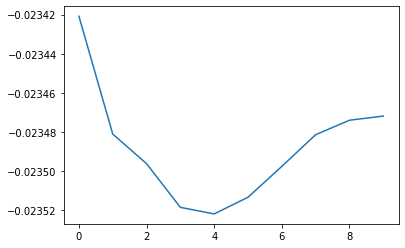

In [177]:
plt.plot(losshistory)

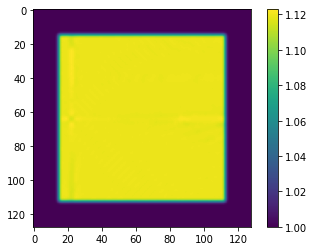

In [178]:
opt_sos_array = get_params(opt_state)
sos_map = sos_func(opt_sos_array)
plt.imshow(sos_map)
plt.colorbar()

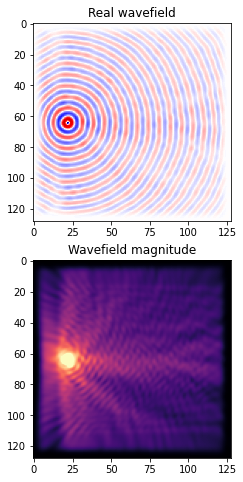

In [174]:
show_field(field)

In [116]:
from jwave.acoustics import ongrid_helmholtz_solver
from jax import jit

def setup_simulation(medium, solver="gmres"):
    params, solver = ongrid_helmholtz_solver(
        medium, 
        omega=omega,
        tol=1e-5, 
        restart=5,
        method=solver,
        maxiter=1000,
        source = src_field
    )
    return params, jit(solver)